# Introduction

In the following notebook, I will be analyzing patient data from the UCI Heart Disease [Dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease). This dataset contains heart health information of patients diagnosed with/without heart disease. 

Note: This dataset originally had 75 attributes. Due to data corruption issues, only 14 attributes remain. 

In this notebook, I will be performing the following:
- Exploratory Data Analysis using Seaborn and Matplotlib
- AUC/ROC, Confusion Matrix
- Stratified K-Fold Cross Validation
- Hyperparamter optimization using Random and Grid Search techniques
- Creating a classifier
- Machine learning Pipeline

Let's begin.

**Load Libraries and Read in Data**

In [75]:
# Read in Libraries
import pandas_profiling
import pandas as pd

import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
#Import warnings filter
from warnings import simplefilter

#Ignore future warnings
simplefilter(action='ignore', category=FutureWarning)

#Set Plot Style for Notebook
sns.set(style="whitegrid")

In [76]:
#Read in Data
df = pd.read_csv("heart.csv")

# Data Preview

 **Variable Description**

UCI and Kaggle datasets reflect incorrect variable information, utilizing data dictionary corrections provided [here](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005).

 age: The person's age in years

 sex: The person's sex (1 = male, 0 = female)

 cp: The chest pain experienced (Value 0: asymptomatic, Value 1: atypical angina,Value 2: non-anginal pain, Value 3: typical angina)

 trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)

 chol: The person's cholesterol measurement in mg/dl

 fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

 restecg: Resting electrocardiographic measurement (0 = showing probable or definite left ventricular hypertrophy by Estes' criteria,  1 = normal,  2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))

 thalach: The person's maximum heart rate achieved

 exang: Exercise induced angina (1 = yes; 0 = no)

 oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)

 slope: slope: the slope of the peak exercise ST segment (0 = downsloping,  1 = flat,  2 = upsloping)

 ca: The number of major vessels (0-3)

 thal: A blood disorder called thalassemia (1 = fixed defect, 2 = normal, 3 = reversable defect)

 target: Heart disease (0 = disease, 1 = no disease)

In [77]:
#Create Pandas Profiling Report
#profile = df.profile_report(title='Pandas Profiling Report')

#Print Report
#profile

#Create html file of Profile Report
#profile.to_file(output_file="Heart Disease Pandas Report.html")

# Data Cleaning

Remove duplicate rows

In [78]:
#Drop duplicate rows
df.drop_duplicates(inplace = True)

Remove rows containing anomalies in **ca** and **thal** columns

In [79]:
#Remove ca anomalies
df.drop(df[df['ca'] == 4].index, inplace=True)

#Remove thal anomalies
df.drop(df[df['thal'] == 0].index, inplace=True)

Update column headers with more informative names

In [80]:
#New column names
names= ['Age', 'Sex', 'Chest_Pain', 'Rest_BP', 'Cholesterol', 'FBS_Over_120mg/dl',
        'Rest_EKG', 'Max_HR', 'Exercise_Induced_Angina','ST_Depression', 
        'ST_Slope', 'Num_Major_Vessels', 'Thalassemia', 'Target']

#Assign Names
df.columns = names

Due to data corruption issues, updating categorical values in the dataset as defined by updated [data dictionary](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005)

In [81]:
#Update Chest_Pain
df.loc[df['Chest_Pain'] == 0, 'Chest_Pain'] = 'Asymptomatic'
df.loc[df['Chest_Pain'] == 1, 'Chest_Pain'] = 'Atypical Angina'
df.loc[df['Chest_Pain'] == 2, 'Chest_Pain'] = 'Non-anginal Pain'
df.loc[df['Chest_Pain'] == 3, 'Chest_Pain'] = 'Typical Angina'


#Update Resting_ECG
df.loc[df['Rest_EKG'] == 0, 'Rest_EKG'] = 'Left ventricular hypertrophy'
df.loc[df['Rest_EKG'] == 1, 'Rest_EKG'] = 'Normal'
df.loc[df['Rest_EKG'] == 2, 'Rest_EKG'] = 'ST-T wave abnormality'


#Update ST_Slope
df.loc[df['ST_Slope'] == 0, 'ST_Slope'] = 'Downsloping'
df.loc[df['ST_Slope'] == 1, 'ST_Slope'] = 'Flat'
df.loc[df['ST_Slope'] == 2, 'ST_Slope'] = 'Upsloping'


#Update Thalassemia
df.loc[df['Thalassemia'] == 1, 'Thalassemia'] = 'Fixed defect'
df.loc[df['Thalassemia'] == 2, 'Thalassemia'] = 'Normal'
df.loc[df['Thalassemia'] == 3, 'Thalassemia'] = 'Reversable defect'

Create dummy variables for categorical variables and assign to dummies data frame. Reorganize column order such that **target** is at index 0.

In [82]:
#Create dummy variables for categorical variables
dummies = pd.get_dummies(df)

#Create list of column headers 
cols = dummies.columns.to_list()

#Move Target to front of cols
cols.insert(0, cols.pop(cols.index('Target')))

#Reindex dummies with cols 
dummies = dummies.reindex(columns= cols)

Check dummies to confirm all categorical datas have been converted properly.

In [83]:
#Display all columns of df
pd.set_option('display.max_columns', 35)

#Missed Num_Major_Vessels
dummies = pd.get_dummies(dummies, columns=['Num_Major_Vessels'])

#Check
dummies.head()

,Target,Age,Sex,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Max_HR,Exercise_Induced_Angina,ST_Depression,Chest_Pain_Asymptomatic,Chest_Pain_Atypical Angina,Chest_Pain_Non-anginal Pain,Chest_Pain_Typical Angina,Rest_EKG_Left ventricular hypertrophy,Rest_EKG_Normal,Rest_EKG_ST-T wave abnormality,ST_Slope_Downsloping,ST_Slope_Flat,ST_Slope_Upsloping,Thalassemia_Fixed defect,Thalassemia_Normal,Thalassemia_Reversable defect,Num_Major_Vessels_0,Num_Major_Vessels_1,Num_Major_Vessels_2,Num_Major_Vessels_3
0,1,63,1,145,233,1,150,0,2.3,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
1,1,37,1,130,250,0,187,0,3.5,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
2,1,41,0,130,204,0,172,0,1.4,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0
3,1,56,1,120,236,0,178,0,0.8,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,1,57,0,120,354,0,163,1,0.6,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0


# Exploratory Data Analysis

Let's begin by taking a look at the correlation matrix and heatmap

In [84]:
#Compute correlation matrix
corr = dummies.corr()

print(corr.Target.sort_values(ascending=False).head(5))

print(corr.Target.sort_values(ascending=False).tail(5))

Target                 1.000000
Thalassemia_Normal     0.530032
Num_Major_Vessels_0    0.488146
Max_HR                 0.426655
ST_Slope_Upsloping     0.386007
Name: Target, dtype: float64
ST_Slope_Flat                   -0.354225
Exercise_Induced_Angina         -0.425085
ST_Depression                   -0.428804
Thalassemia_Reversable defect   -0.489046
Chest_Pain_Asymptomatic         -0.505149
Name: Target, dtype: float64


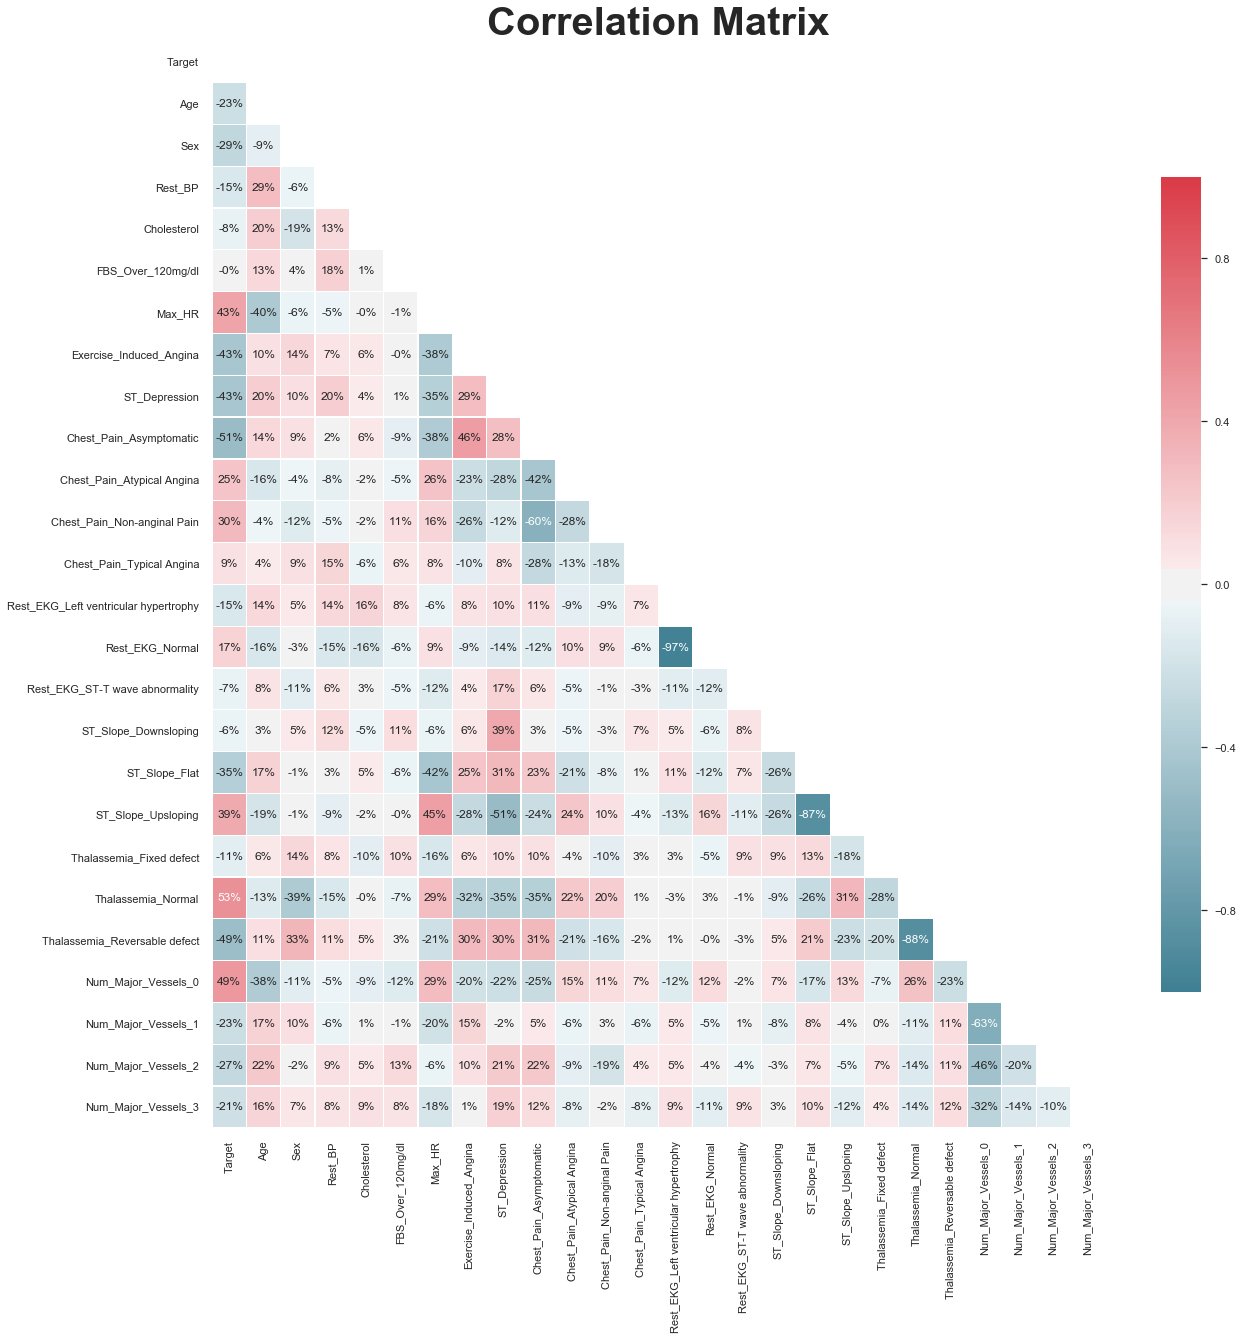

In [85]:
#Set figure size
fig, ax = plt.subplots(figsize=(20,20))

#Generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

#Create custom cmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Plot heatmap
g = sns.heatmap(corr, vmin=-1, vmax=1, center = 0,mask=mask,
               linewidth = .25, annot=True,fmt='.0%',
                cbar_kws={"shrink":.75},
               cmap= cmap, ax=ax)

#Set plot title
g.set_title('Correlation Matrix', fontsize = 40, fontweight='heavy');

**Rates of Heart Disease between Men and Women**



In [86]:
print(df.groupby(['Sex','Target'])['Target'].size())

Sex  Target
0    0          24
     1          71
1    0         112
     1          89
Name: Target, dtype: int64


Heart Disease counts by gender:
Sex  Target
0    0          24
     1          71
1    0         112
     1          89
Name: Target, dtype: int64


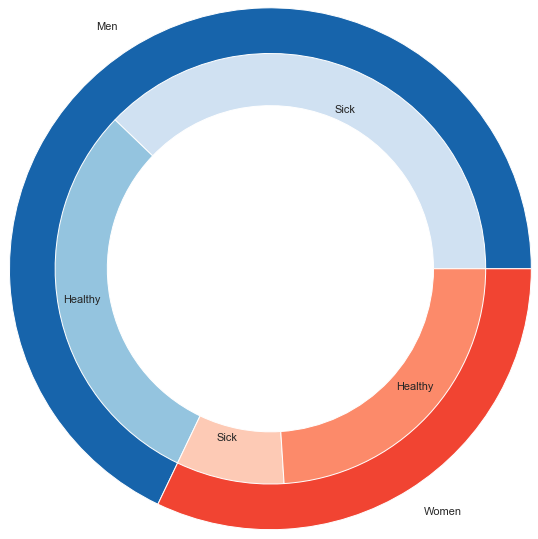

In [87]:
#Print heart disease counts by Sex(0=disease, 1= no disease)
print('Heart Disease counts by gender:')
print(df.groupby(['Sex','Target'])['Target'].size())

# Make data: I have 2 groups and 4 subgroups
group_names=['Men', 'Women']
group_size=[201,95]
subgroup_names=['Sick', 'Healthy', 'Sick', 'Healthy']
subgroup_size=[112,89,24,71]
 
# Create colors
Men, Women =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(6,6))

ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=2, labels=group_names, colors=[Men(0.8), Women(0.6)])

plt.setp(mypie, width=0.6, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=2-0.35, labels=subgroup_names, 
                   labeldistance=0.8, rotatelabels =0,
                   colors=[Men(0.2), Men(0.4), Women(0.2), Women(0.4)])

plt.setp(mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

#Set Title


# show it
plt.show()


In our dataset, men outnumber women by quite a bit. However, the proportion of sick to healthy individuals between the sexes is very interesting but not super surprising. We do know that men are more likely to suffer from heart related illnesses that women ([source](https://www.telegraph.co.uk/men/active/mens-health/11723374/Why-do-men-suffer-more-heart-problems-than-women.html)).

Let's take a look into some of the factors that contribute to heart disease, starting with patient blood pressure at the time of admittance to the hospital.

**Resting BP and Rates of Heart Disease by Gender**

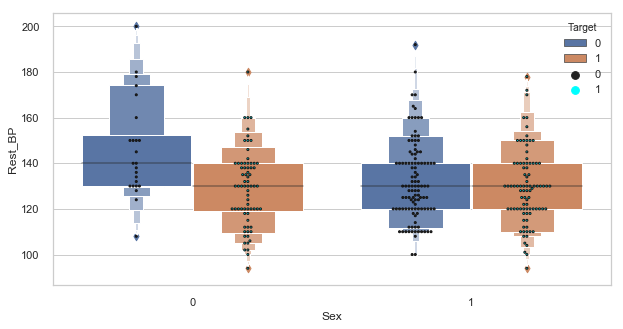

In [88]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

#Plot
g = sns.boxenplot(x='Sex', y='Rest_BP', hue = 'Target', 
                  #labels= ['No Disease', 'Disease'],
                  dodge=True,
                  data = df, ax=ax)

# Add in points to show each observation
sns.swarmplot(x="Sex", y="Rest_BP", hue ='Target', data=df,dodge=True,
              size=2, color="cyan", linewidth=1)
#Set Legend Labels
#g.legend(labels= ['No Disease', 'Disease'])

Those with higher cholesterol tend to be heart healthy?!

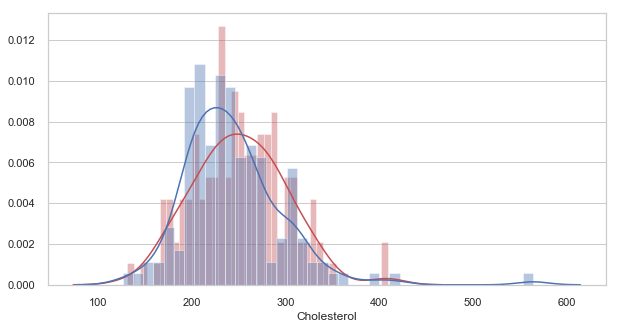

In [89]:
#plot
fig, ax = plt.subplots(figsize = (10,5))
#Disease
g = sns.distplot(df['Cholesterol'][df['Target'] == 0], bins = 40, 
                 color = 'r', ax=ax)

#Healthy
k=sns.distplot(df['Cholesterol'][df['Target'] == 1], bins=40, 
               color = 'b', ax=ax)


#Mute vertical grid lines
ax.xaxis.grid()

Chest pain

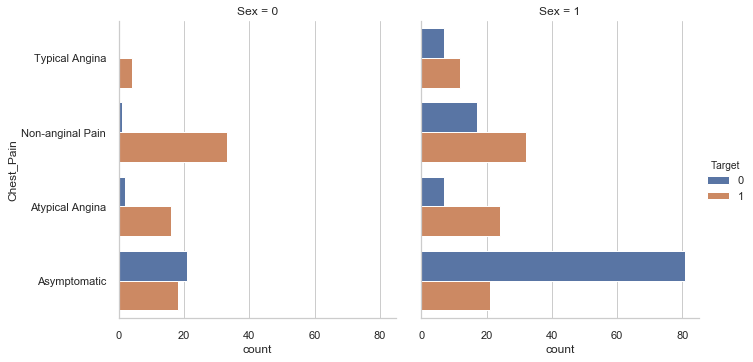

In [90]:
#Chest pain and disease for men and women
sns.catplot(y='Chest_Pain',col = 'Sex', hue='Target', 
            kind = 'count',data=df)

Most disease patients are asymptomatic for chestpain

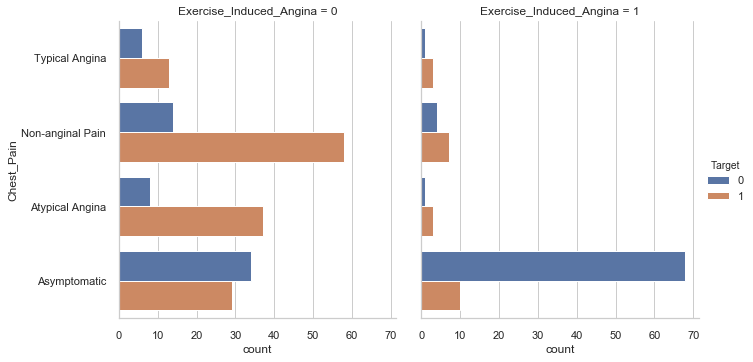

In [91]:
sns.catplot(y='Chest_Pain',col = 'Exercise_Induced_Angina', hue='Target', 
            kind = 'count',data=df)

# Let's look into the heart

Thalassmia

What is thalessmia?

Thalassemia is a blood disorder passed down through families (inherited) in which the body makes an abnormal form or inadequate amount of hemoglobin. Hemoglobin is the protein in red blood cells that carries oxygen. The disorder results in large numbers of red blood cells being destroyed, which leads to anemia.

What is Thalium? Nuclear stress testing requires the injection of a tracer, commonly technicium 99M (Myoview or Cardiolyte), which is then taken up by healthy, viable myocardial cells. A camera (detector) is used afterwards to image the heart and compare segments. A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. This is called a "reversible defect." Scarred myocardium from prior infarct will not take up tracer at all and is referred to as a "fixed defect.

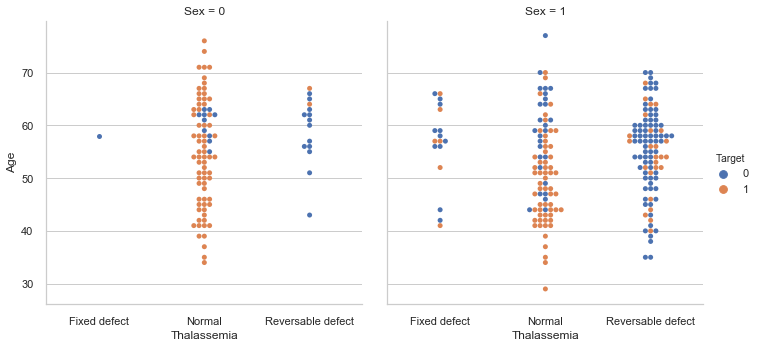

In [92]:
#sns.swarmplot(x='Thalassemia', y= 'Age',size = 5, hue='Target', data=df)
sns.catplot(x='Thalassemia', y= 'Age', hue='Target',
            col= 'Sex', 
            kind='swarm',data=df)

ST Slope

What is ST Depression?

ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline.
The ST Segment represents the interval between ventricular depolarization and repolarization.
**The most important cause of ST segment abnormality (elevation or depression) is myocardial ischaemia or infarction**

Morphology of ST Depression
ST depression can be either upsloping, downsloping, or horizontal (see diagram below).
Horizontal or downsloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischaemia (according to the 2007 Task Force Criteria).
ST depression ≥ 1 mm is more specific and conveys a worse prognosis.
ST depression ≥ 2 mm in ≥ 3 leads is associated with a high probability of NSTEMI and predicts significant mortality (35% mortality at 30 days).
Upsloping ST depression is non-specific for myocardial ischaemia.

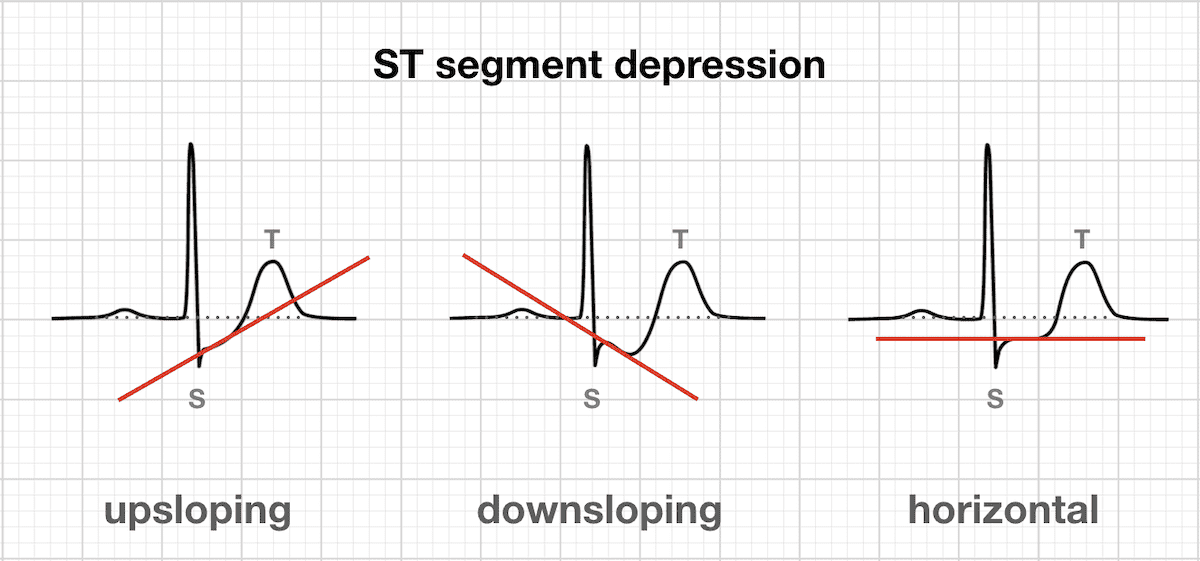

In [93]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "ST Slope.png", height=600, width =600)

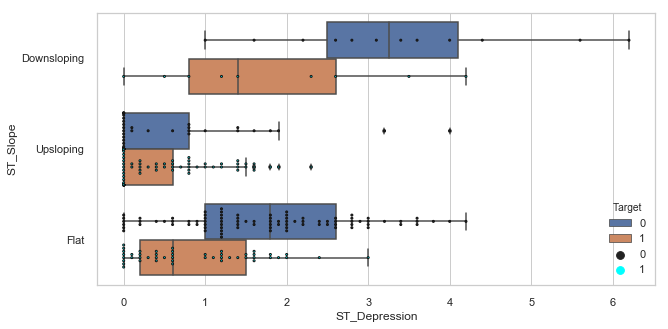

In [94]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

#Plot 
g=sns.boxplot('ST_Depression', 'ST_Slope', hue ='Target',
                data = df, ax=ax)

# Add in points to show each observation
sns.swarmplot(x="ST_Depression", y="ST_Slope", hue ='Target', data=df,
              size=2, color="cyan",dodge=True, linewidth=1)

Upsloping ST depression is non-specific for myocardial ischaemia.
Horizontal or downsloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischaemia (according to the 2007 Task Force Criteria)

# Maximum HR , slope and age

In [95]:
df.head(1)

,Age,Sex,Chest_Pain,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Rest_EKG,Max_HR,Exercise_Induced_Angina,ST_Depression,ST_Slope,Num_Major_Vessels,Thalassemia,Target
0,63,1,Typical Angina,145,233,1,Left ventricular hypertrophy,150,0,2.3,Downsloping,0,Fixed defect,1


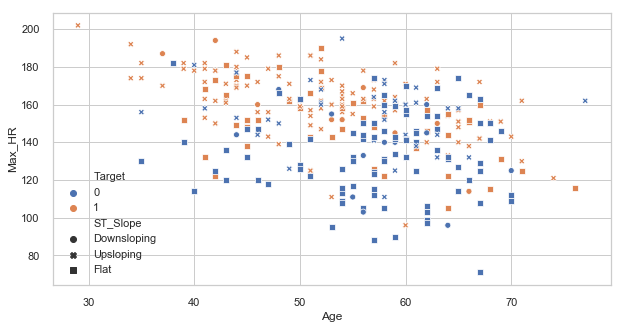

In [96]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

g=sns.scatterplot('Age', 'Max_HR', hue='Target', style='ST_Slope',sizes=5,
                  #size='Exercise_Induced_Angina',
                  y_jitter=True, x_jitter=True, data = df, ax=ax)

In [97]:
df.Rest_EKG

0      Left ventricular hypertrophy
1                            Normal
2      Left ventricular hypertrophy
3                            Normal
4                            Normal
                   ...             
298                          Normal
299                          Normal
300                          Normal
301                          Normal
302    Left ventricular hypertrophy
Name: Rest_EKG, Length: 296, dtype: object

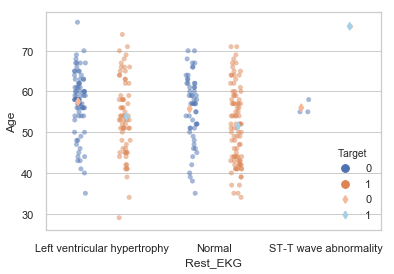

In [98]:
sns.stripplot('Rest_EKG', 'Age',hue='Target', 
              dodge=True, jitter=True,
              alpha=.5, zorder=1,
              data=df)

# Show the conditional means
sns.pointplot('Rest_EKG', 'Age',hue='Target',
              data=df, dodge= .434, join=False, palette="RdBu",
              markers="d", scale=.75, ci=None)

Fluoroscopy

Fluoroscopy is a study of moving body structures--similar to an X-ray "movie." A continuous X-ray beam is passed through the body part being examined. The beam is transmitted to a TV-like monitor so that the body part and its motion can be seen in detail. 

Fluoroscopy may be performed to evaluate specific areas of the body, including the bones, muscles, and joints, as well as solid organs, such as the heart, lung, or kidneys.

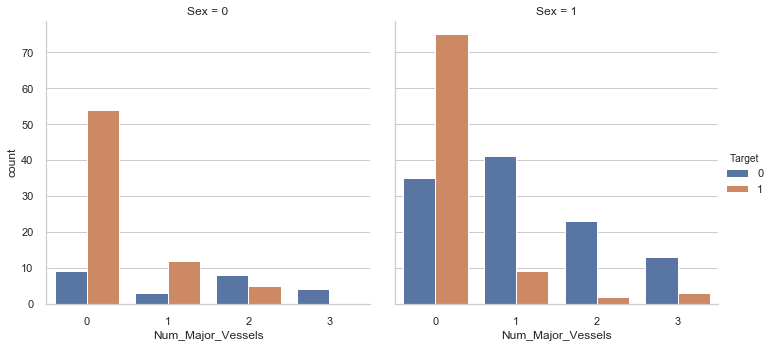

In [99]:
sns.catplot('Num_Major_Vessels', kind='count', col='Sex',hue= 'Target', 
           data=df)

Num valves?

# Machine Learning

Over arching goal: Reduce the number of false positives as much as possible. 

In this data set, a positive result means that the patient has NO HEART DISEASE. A negative result means that the patient has HEART DISEASE.

Misclassifying a health patient with heart disease(when they are healthy) is far less disasterous then letting a sick patient return home with undiagnosed heart disease.

precision is what we are after. Precision measures how many of the samples predicted as positive are actually positive.

Equation:


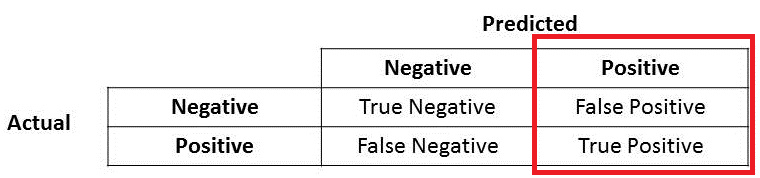

In [100]:
Image(filename="Precision Confusion Matrix.png", height=600, width =600)

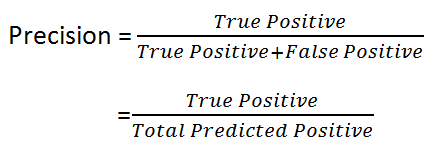

In [101]:
Image(filename= "Precision Equation.png", height=600, width =600)

Recall is the measure of how many positive samples are captured by positive predictions. Ideal when we want to avoid false negatives.

- Normalize/standardize data
- Stats of classes
- Fit base models
- Confusion Matrix
- AUC/ROC
- Stratified CV
- Grid/random CV
    - Visualize CV
-Make a pipeline
    


### Data Preprocessing

View feature distributions for data preprocessing purposes

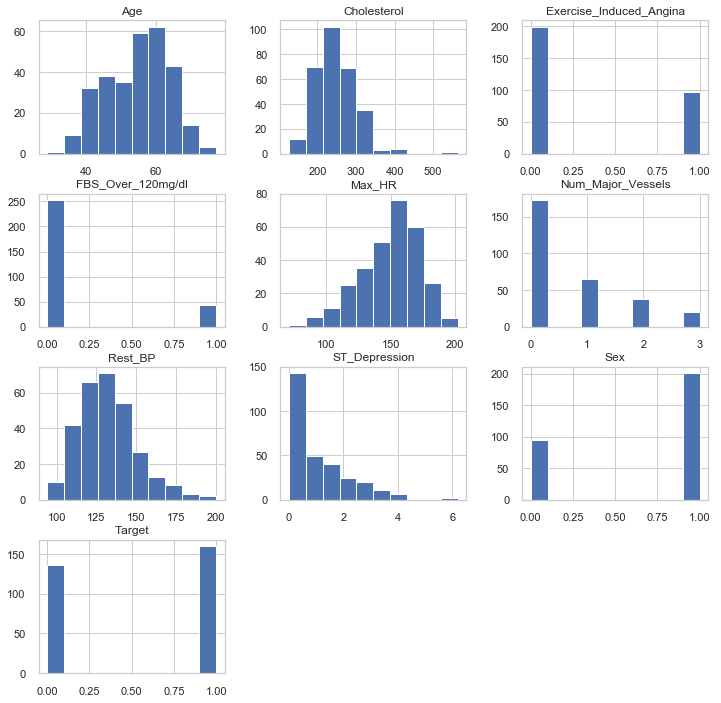

In [102]:
#View feature distributions
df.hist(figsize=(12,12));

Applying log transformations to ST_Depression, Rest_BP, and Cholesterol. Applying square transformation to Max_HR.

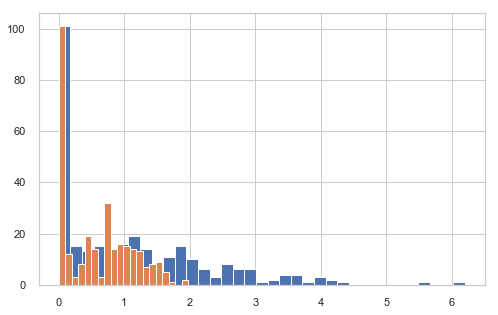

In [103]:
#ST_Depression
fig, ax= plt.subplots(figsize=(8,5))

g = dummies.ST_Depression.hist(bins=35, ax=ax)

k = np.log(dummies['ST_Depression']+1).hist(bins=20, ax=ax)

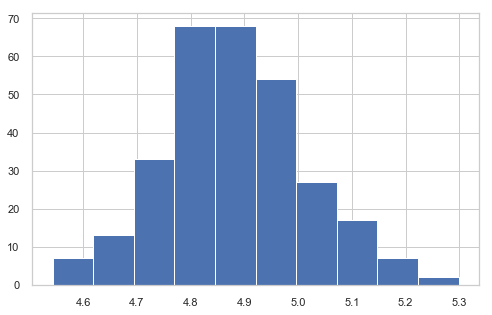

In [104]:
k = np.log(dummies['Rest_BP']).hist(bins=10, figsize=(8,5))

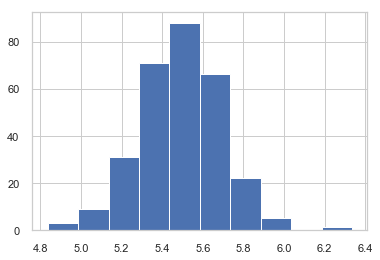

In [105]:
np.log(dummies.Cholesterol).hist()

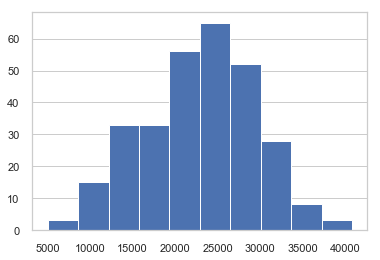

In [106]:
np.square(dummies.Max_HR).hist()
plt.grid(False, axis = 'x')

Apply Transformations

In [107]:
dummies.ST_Depression = np.log(dummies.ST_Depression+1)
dummies.Rest_BP = np.log(dummies.Rest_BP)
dummies.Cholesterol = np.log(dummies.Cholesterol)
dummies.Max_HR= np.square(dummies.Max_HR)

In [108]:
#Seperate training/validation data from target. Convert into arrays
y= dummies.Target.values
X= dummies.drop(columns=['Target']).values

#Check Shape
print('y shape: ',y.shape)
print('X shape: ',X.shape)

y shape:  (296,)
X shape:  (296, 25)


# Pipeline Base Models
- Logistic Regression
- KNN
- Decision Tree
- Naive Bayes

Pipelines let us glue together multiple processing steps to avoid leaking information into our model

Preprocessing

In [116]:
#import pipeline class
from sklearn.pipeline import Pipeline

#Import preprocessing
from sklearn import preprocessing

#Import Cross validation methods
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [118]:
#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Instantiate Pipeline
pipe = Pipeline([('scaler', preprocessing.MinMaxScaler()), ('classifier', LogisticRegression())])

#Set param_grid with base models
param_grid = [
    {'classifier':[LogisticRegression()], 'scaler': [preprocessing.MinMaxScaler(), 
                                                     preprocessing.StandardScaler(), 
                                                     preprocessing.RobustScaler()]},
    {'classifier': [DecisionTreeClassifier(random_state=0)], 'scaler': [None]},
    {'classifier':[GaussianNB()],'scaler': [preprocessing.MinMaxScaler(), 
                                            preprocessing.StandardScaler(), 
                                            preprocessing.RobustScaler()]}   
]

#Import Stratified K-Folds cross-validator
from sklearn.model_selection import StratifiedKFold

#Instantiate cross validator
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

#Split Data into training and test sets
skf.get_n_splits(X,y)

#Check splits
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#Use Grid Search to select best base model
grid = GridSearchCV(pipe, param_grid, cv=5)
    
#Fit Grid
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

Best cross-validation score: 0.87
Test-set score: 0.84


C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [120]:
X_test.shape

(98, 25)

Split Data into Training and Test data using Stratified Cross Validation

In [ ]:
# #Import Stratified K-Folds cross-validator
# from sklearn.model_selection import StratifiedKFold

# #Instantiate cross validator
# skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# #Split Data into training and test sets
# skf.get_n_splits(X,y)

# #Check splits
# for train_index, test_index in skf.split(X, y):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

Scale the data

In [ ]:
# #Import MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# #Instantiate model
# scaler = MinMaxScaler()

# #Fit scaler to training data
# scaler.fit(X_train)

# #Transform Data
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Metrics

In [ ]:
#Import Metrics


In [ ]:
# #Import Metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report


# #Target Stats
# print('Target Counts: \n', dummies.Target.value_counts())

# #Instantiate confusion_matrix and view results of logr
# confusion = confusion_matrix(y_test, pred_logr)

# #Print confusion matrix 
# print('\nLog Regression Confusion Matrix: \n {}'.format(confusion))
# #print('Confusion matrix accuracy: {:.3f}'.format())

# target_names= ['Heart Disease', 'Healthy']
# print("\nClassification Report: \n",classification_report(y_test, pred_logr, target_names=target_names))

Increase threshold to decrease positives

In [ ]:
# pred_y_lower_thresh = logr.decision_function(X_test_scaled) > 1.0
# print("\nClassification Report: \n",classification_report(y_test, pred_y_lower_thresh, target_names=target_names))

## Curves

**Precision recall curves**

Let's look at all possible threshold values for precision and recall at once

In [ ]:
# from sklearn.metrics import precision_recall_curve

# precision, recall, thresholds = precision_recall_curve(
#     y_test, pred_logr)


# # find threshold closest to zero
# close_zero = np.argmin(np.abs(thresholds))
# plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
#          label="threshold zero", fillstyle="none", c='k', mew=2)

# plt.plot(precision, recall, label="precision recall curve")
# plt.xlabel("Precision")
# plt.ylabel("Recall")

# plt.grid(linewidth=.4)
# plt.legend(loc='best', frameon=True);


In [ ]:
# #import roc curve
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(
# y_test, pred_logr)

# #Set fig size
# fig, ax = plt.subplots(figsize=(6,6))

# #Plot Curve
# ax.plot(fpr, tpr, label = 'ROC_Curve')

# #Set Axis Labels
# ax.set_xlabel("FPR")
# ax.set_ylabel("TPR(Recall)")

# #Find Threshold closest to 0
# close_zero = np.argmin(np.abs(thresholds))
# ax.plot(fpr[close_zero], tpr[close_zero], 'o',
#         markersize=10, fillstyle='none', c='red', mew=2, label='Threshold Zero')

# ax.grid(linewidth=.4)
# ax.legend(loc=4, frameon=True);

# #Summon roc_auc_score
# from sklearn.metrics import roc_auc_score
# logr_auc = roc_auc_score(y_test,logr.predict_proba(X_test_scaled)[:,1])

# #Calculate AUC
# print("AUC for logistic Regression: {:.3f}".format(logr_auc))

In [ ]:
# pred_y_lower_thresh = logr.decision_function(X_test_scaled) > 1.0
# print("\nClassification Report: \n",classification_report(y_test, pred_y_lower_thresh, target_names=target_names))

In [ ]:
# fpr, tpr, thresholds = roc_curve(
# y_test, pred_y_lower_thresh)

# #Set fig size
# fig, ax = plt.subplots(figsize=(6,6))

# #Plot Curve
# ax.plot(fpr, tpr, label = 'ROC_Curve')

# #Set Axis Labels
# ax.set_xlabel("FPR")
# ax.set_ylabel("TPR(Recall)")

# #Find Threshold closest to 0
# close_zero = np.argmin(np.abs(thresholds))
# ax.plot(fpr[close_zero], tpr[close_zero], 'o',
#         markersize=10, fillstyle='none', c='red', mew=2, label='Threshold Zero')

# ax.grid(linewidth=.4)
# ax.legend(loc=4, frameon=True);

# #Summon roc_auc_score
# from sklearn.metrics import roc_auc_score
# logr_auc = roc_auc_score(y_test,pred_y_lower_thresh)

# #Calculate AUC
# print("AUC for logistic Regression: {:.3f}".format(logr_auc))

#### Statistical Analysis of Logistic Regression

In [ ]:
# #Prepare data to be fit to model
# #Shape labels
# y = df['Target']
# print("Target Shape: ", y.shape)

# #Shape Data 
# x = df.drop('Target', axis = 1)
# print(x.shape)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# #Instantiate the Model
# tree = DecisionTreeClassifier(random_state=0)

# #Split the data
# X_train, X_test, y_train, y_test= train_test_split(
# x, y, random_state = 42)

# #fit data
# tree.fit(X_train,y_train)

# #predict
# print(tree.predict(X_test))

# #score
# print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
# print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))


 Without any pruning, the model will overfit on the training data. Let's attempt to prune our tree and see if we can improve the 73.7% test result and reduce the overfitting

In [ ]:
# #Prune the max number of levels by adjusting the max_depth parameter

# #Instantiate the model
# tree = DecisionTreeClassifier(random_state=0, max_depth=5)

# #fit the data
# tree.fit(X_train, y_train)

# #Results
# print("Accuracy on the training data: {:.3f}".format(tree.score(X_train, y_train)))
# print("Accuracy on the test data: {:.3f}".format(tree.score(X_test, y_test)))


 Slightly less overfitting but marginal increse on the training data

In [ ]:
# #Create a function to plot the feature importance of the model
# feature_names = list(df.columns.values)

# def plot_feature_importances(model):
#     n_features = x.shape[1]
#     plt.barh(np.arange(n_features), model.feature_importances_, align='center')
#     plt.yticks(np.arange(n_features), feature_names)
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")
#     plt.ylim(-1, n_features)

# plot_feature_importances(tree)

# print("Feature importances: ", tree.feature_importances_)



Let's play with the min_samples_split

In [ ]:
# #Update model
# tree = DecisionTreeClassifier(random_state= 42, min_samples_split=10)

# #fit Data

# tree.fit(X_train, y_train)

# print("Model Accuracy on the training data: {:.3f}".format(tree.score(X_train, y_train)))
# print("Model Accuracy on the data: {:.3f}".format(tree.score(X_test, y_test)))

In [ ]:
# #Let's check out min_samples_leaf
# tree = DecisionTreeClassifier(random_state= 42, min_samples_leaf=6)

# #Fit Data
# tree.fit(X_train, y_train)

# #Results
# print("Model Accuracy on training data: {:.3f}".format(tree.score(X_train,y_train)))
# print("Model Accuracy on test data: {:.3f}".format(tree.score(X_test,y_test)))


In [ ]:
# #Set up new model
# tree = DecisionTreeClassifier(random_state=42, max_features=8)

# #Fit the Data
# tree.fit(X_train, y_train)

# #Score the results
# print("Model accuracy on the training data: {:.3f}".format(tree.score(X_train,y_train)))
# print("Model accuracy on the test data: {:.3f}".format(tree.score(X_test,y_test)))


Let's try to improve our model some with a mix of pruning strategies

In [ ]:
# tree = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=7, max_features=9)

# #Fit the data
# tree.fit(X_train,y_train)

# #Results
# print("Model accuracy on the training data is: {:.3}".format(tree.score(X_train, y_train)))
# print("Model accuracy on the test data is: {:.3}".format(tree.score(X_test, y_test)))

Overall, we were able to improve our model's performance significantly by pruning however I am concerned our current model is slightly underfitting the training data. A Decision Tree Classifier may not have been an ideal model for this data set but no worries, we will attempt another model in the future.